# Introduction

Diabetes is a chronic medical condition characterized by high levels of glucose in the blood. It is a major health concern worldwide, affecting millions of people. There are primarily two types of diabetes: Type 1 and Type 2. Type 1 diabetes is an autoimmune condition where the body attacks insulin-producing cells, while Type 2 diabetes is characterized by insulin resistance and is often associated with lifestyle factors. Our dataset has a different approach to providing an indicators for different onsets of diabetes: 0 for no diabetes or diabetes only during the pregnancy, 1 for the prediabetes, 2 for having diabetes of either type 1 or type 2 (no differentiation between them). 

**The goal of this project is to predict the onset of diabetes based on the patient's answers to a survey.**

For the purposes of milestone 2 and 3, we will explore the dataset of about 250k patient answers to survays to understand the factors that contribute to the onset of diabetes. The data is taken from BRFSS survay conducted yearly on the american population. The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC. Each year, the survey collects responses 
from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services. It has been conducted every year since 1984.

The meaning of the columns in the dataset will be explained in the next section, but for reference here is the document explaining all the columns in the survay, only 22 of which we use: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf
We will use machine learning models to predict the onset of diabetes based on the patient's answers to the survey questions. 
We will also explore the dataset to identify trends and patterns that may be useful in understanding the risk factors for diabetes.

## Imports

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import imblearn 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# IMPORT DATA
df = pd.read_csv('data/diabetes_predictors/diabetes_indicators.csv')

df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


This dataset contains 22 predictors, capturing a wide range of health, lifestyle, and demographic indicators. Most of these predictors are categorical or binary variables, such as **Smoker** (indicating if the individual smokes), **HighBP** (presence of high blood pressure), and **HeartDiseaseorAttack** (indicating a history of heart disease or heart attack). Some variables, like **Sex** and **Age**, are also categorical but represent demographic information.

One notable continuous variable is **BMI** (Body Mass Index), which could either be analyzed as is or transformed into categories (e.g., "Underweight," "Normal," "Overweight," and "Obese") based on widely accepted benchmarks. This transformation would allow for a more interpretable understanding of how different BMI ranges correlate with health outcomes.

In addition to health indicators, several other variables assess general well-being or access to care, such as **GenHlth** (general health), **MentHlth** (mental health), **PhysHlth** (physical health), **Education**, and **Income**. These variables are numerical, often representing different levels or frequencies, and could be grouped into broader categories like “low,” “moderate,” or “high,” which may simplify analysis and enhance interpretability. 

Overall, this dataset combines categorical, binary, and continuous data, providing a rich foundation for statistical analysis and predictive modeling. By examining the relationships between these predictors and outcomes like **Diabetes_012**, we can derive insights into the risk factors and associations between lifestyle, demographic factors, and health conditions. This structure supports both classification and regression modeling, allowing for nuanced analysis and valuable insights into public health trends and risk factors.

## Examining the dataset for missing values
Examining the dataset, none of the values are missing which is great since we can continue on with further analysis.

In [3]:
# Show how many missing entries are in each column
df.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

## Finding mbalanced classes
To handle class imbalance in **Diabetes_012**, we’ll use **SMOTE (Synthetic Minority Over-sampling Technique)** to create extra examples for the minority class (diabetes cases). This method balances the dataset without losing any data, helping the model better identify patterns in diabetes cases and improving overall accuracy.

In [4]:
# Balancing the classes
df['Diabetes_012'].value_counts()

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

## What does SMOTE do?
SMOTE stands for Synthetic Minority Over-sampling Technique. It is used in machine learning to address the issue of imbalanced datasets, where one class has significantly fewer samples than the other(s). SMOTE identifies the minority class in your dataset, which is the class with fewer samples. Instead of simply duplicating the existing samples of the minority class, SMOTE generates new synthetic samples. It does this by selecting two or more similar instances from the minority class and creating new instances that are combinations of these instances. By adding these synthetic samples to the minority class, SMOTE helps balance the dataset, making the number of samples in each class more equal.

In [5]:
smote = SMOTE(random_state=42)
predictors = df.drop('Diabetes_012', axis=1)
target = df['Diabetes_012']
predictors_resampled, target_resampled = smote.fit_resample(predictors, target)
# check balance
target_resampled.value_counts()

Diabetes_012
0.0    213703
2.0    213703
1.0    213703
Name: count, dtype: int64

In [6]:
df = pd.DataFrame(predictors_resampled, columns=predictors.columns)

df['Diabetes_012'] = target_resampled

print(df.head())
num_rows = df.shape[0]
num_rows

   HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0        1.0  40.0     1.0     0.0                   0.0   
1     0.0       0.0        0.0  25.0     1.0     0.0                   0.0   
2     1.0       1.0        1.0  28.0     0.0     0.0                   0.0   
3     1.0       0.0        1.0  27.0     0.0     0.0                   0.0   
4     1.0       1.0        1.0  24.0     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  ...  NoDocbcCost  GenHlth  MentHlth  \
0           0.0     0.0      1.0  ...          0.0      5.0      18.0   
1           1.0     0.0      0.0  ...          1.0      3.0       0.0   
2           0.0     1.0      0.0  ...          1.0      5.0      30.0   
3           1.0     1.0      1.0  ...          0.0      2.0       0.0   
4           1.0     1.0      1.0  ...          0.0      2.0       3.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  Diabetes_012  
0      15.0       1.0  0

641109

## Differences in the scale of features
For our dataset, we need to address the varying scales and types of features, such as **BMI**, health scores, **Education**, and **Income**. **BMI** is a continuous variable that could either be standardized or transformed into categories (e.g., 0: underweight, 1: normal, 2: overweight, 3: obese) to improve interpretability. **Education** and **Income** represent categorical levels, so encoding them with ordinal or one-hot encoding would be suitable, depending on model requirements. Health scores like **GenHlth**, **MentHlth**, and **PhysHlth** are numeric but may benefit from either standardization to bring them to a common scale or grouping into broader categories (e.g., low, moderate, high) for simpler analysis. This pre-processing will ensure each feature is represented appropriately and fairly in the model.

In [7]:
# Replacing BMI with categorical values
# Underweight: 0, Normal: 1, Overweight: 2, Obese: 3
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0  
    elif 18.5 <= bmi < 25:
        return 1 
    elif 25 <= bmi < 30:
        return 2  
    else:
        return 3  

if 'BMI' in df.columns:
    df['BMI'] = df['BMI'].apply(categorize_bmi)
else:
    print("Column 'BMI' does not exist in the dataframe.")
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_012
0,1.0,1.0,1.0,3,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0.0
1,0.0,0.0,0.0,2,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0
2,1.0,1.0,1.0,2,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,0.0
3,1.0,0.0,1.0,2,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0.0
4,1.0,1.0,1.0,1,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,0.0


## Income representation
1 - Less than $10,000  
2 - $10,000 to less than $15,000  
3 - $15,000 to less than $20,000  
4 - $20,000 to less than $25,000  
5 - $25,000 to less than $35,000  
6 - $35,000 to less than $50,000  
7 - $50,000 to less than $75,000  
8 - $75,000 or more

The **Income distribution** chart shows that higher income levels (particularly category 8, $75,000 or more) are much more represented than lower-income levels, creating a right-skewed distribution. This imbalance could cause a predictive model to perform better for higher-income individuals while being less accurate for lower-income groups, potentially introducing bias. To address this, we could use resampling techniques like oversampling lower-income categories or undersampling higher-income categories to balance the income levels. Alternatively, we could combine some of the lower-income categories to form broader groups, reducing the impact of this skew.

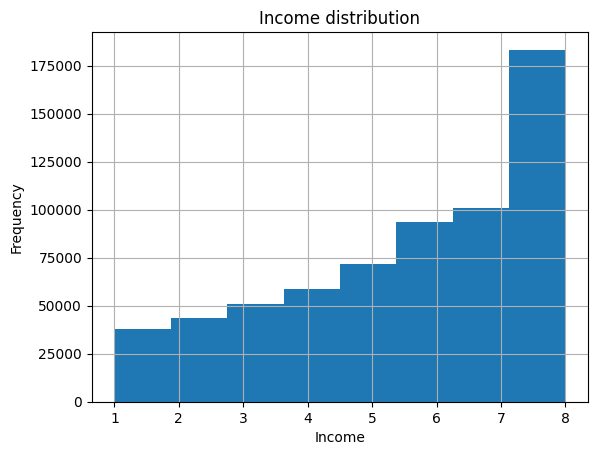

   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1    3       1       0                     0   
1       0         0          0    2       1       0                     0   
2       1         1          1    2       0       0                     0   
3       1         0          1    2       0       0                     0   
4       1         1          1    1       0       0                     0   

   PhysActivity  Fruits  Veggies  ...  PhysHlth  DiffWalk  Sex  Age  \
0             0       0        1  ...        15         1    0    9   
1             1       0        0  ...         0         0    0    7   
2             0       1        0  ...        30         1    0    9   
3             1       1        1  ...         0         0    0   11   
4             1       1        1  ...         0         0    0   11   

   Education  Income  Diabetes_012  Income_Low-income  Income_Mid-income  \
0          4       3             0

In [8]:

df['Income'].hist(bins=8)
plt.title('Income distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()


bins = [0, 3, 7, float('inf')]  # The range boundaries: 0-30k, 30k-70k, 70k+
labels = ['Low-income', 'Mid-income', 'High-income']  

df['Income_group'] = pd.cut(df['Income'], bins=bins, labels=labels, right=True)

df = pd.get_dummies(df, columns=['Income_group'], prefix='Income')

df = df.astype(int)

print(df.head())


## Education representation

1 - Never attended school or only kindergarten  
2 - Grades 1 through 8 (Elementary)  
3 - Grades 9 through 11 (Some high school)  
4 - Grade 12 or GED (High school graduate)  
5 - College 1 to 3 years (Some college or technical school)  
6 - College 4 years or more (College graduate)

This **Education** distribution shows an imbalance, with certain levels being much more represented than lower education levels. This imbalance could introduce bias in a predictive model, making it more tailored to patterns seen in highly educated individuals and potentially reducing accuracy for those with lower education levels. To address this, we could consider resampling techniques to balance the representation of each education level or adjust class weights in certain models. Additionally, since some classes are much less represented we can combine 1 - 3 into 1 category less than highschool or incomplete high school.

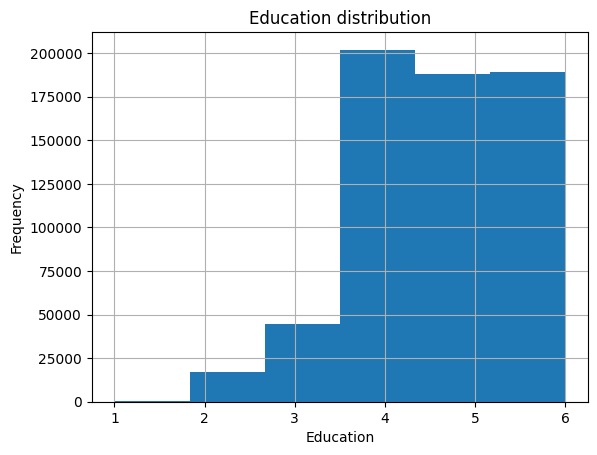

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Income,Diabetes_012,Income_Low-income,Income_Mid-income,Income_High-income,Education_original,Education_1,Education_2,Education_3,Education_4
0,1,1,1,3,1,0,0,0,0,1,...,3,0,1,0,0,2,0,1,0,0
1,0,0,0,2,1,0,0,1,0,0,...,1,0,1,0,0,4,0,0,0,1
2,1,1,1,2,0,0,0,0,1,0,...,8,0,0,0,1,2,0,1,0,0
3,1,0,1,2,0,0,0,1,1,1,...,6,0,0,1,0,1,1,0,0,0
4,1,1,1,1,0,0,0,1,1,1,...,4,0,0,1,0,3,0,0,1,0


In [9]:
# Checking the skewness of the data
# check the distribution of education across the dataset
df['Education'].hist(bins=6)
plt.title('Education distribution')
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.show()

# combine categories 1, 2 and 3 into one category
df['Education'] = df['Education'].replace([1, 2, 3], 1)
df['Education'] = df['Education'].replace(4, 2)
df['Education'] = df['Education'].replace(5, 3)
df['Education'] = df['Education'].replace(6, 4)

# We perform the one hot encoding for the 'Education' column as well
# maintain the original column for now
df['Education_original'] = df['Education']

df = pd.get_dummies(df, columns=['Education'], prefix='Education').astype(int)
df.head()

## Age representation

1 - Age 18 to 24  
2 - Age 25 to 29  
3 - Age 30 to 34  
4 - Age 35 to 39  
5 - Age 40 to 44  
6 - Age 45 to 49  
7 - Age 50 to 54  
8 - Age 55 to 59  
9 - Age 60 to 64  
10 - Age 65 to 69  
11 - Age 70 to 74  
12 - Age 75 to 79  
13 - Age 80 or older

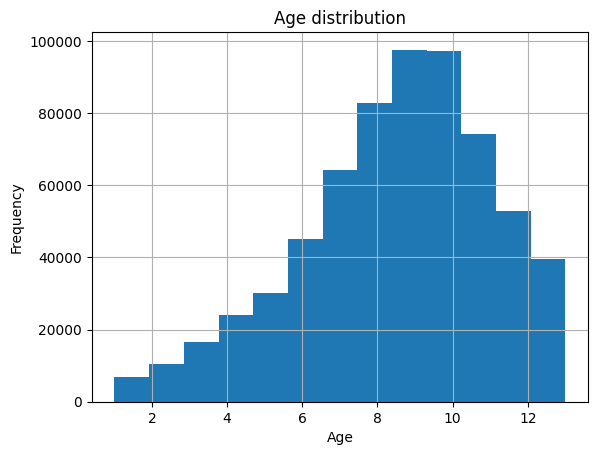

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13
0,1,1,1,3,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,2,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,2,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,1,2,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,1,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0


In [10]:
# check the distribution of ages across the dataset
df['Age'].hist(bins=13)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# We perform the one hot encoding for the 'Age' column as well
# keep the original column for now
df['Age_original'] = df['Age']
df = pd.get_dummies(df, columns=['Age'], prefix='Age').astype(int)
df.head()

## Skewed age
The distribution is left skewed so some categories are more represented than others. The age distribution in our dataset is left-skewed, meaning younger age groups are underrepresented compared to older ones. This skew could lead to the model being less accurate for younger age predictions, as fewer samples might make it harder to learn patterns specific to these age groups. To address this, we could apply resampling techniques to balance the distribution or use stratified sampling to ensure each age group is well-represented in both training and testing sets. However, given the dataset's large size (250,000 rows), even the smaller age groups likely have sufficient data to support learning, reducing the risk of model bias. Therefore, while the skew is present, the high volume of data should largely mitigate its potential impact, allowing the model to perform effectively across all age groups.

## Health Status
The **GenHlth** (General Health) score is represented by five categories indicating self-reported health status:

1 - Excellent  
2 - Very Good  
3 - Good  
4 - Fair  
5 - Poor  

Each category reflects a subjective assessment of overall health, with higher scores indicating poorer health. This ordinal scale allows us to capture a range of health perceptions from "Excellent" to "Poor," which may correlate with other health indicators in the dataset.

**MentHlth** represents the number of days in the past 30 days when a respondent’s mental health was "not good," including experiences of stress, depression, and emotional problems. This numeric variable ranges from 0 to 30, providing an indicator of mental health challenges over the past month.

**PhysHlth** represents the number of days in the past 30 days when a respondent’s physical health was "not good," including experiences of physical illness and injury. This numeric variable ranges from 0 to 30, providing an indicator of physical health challenges over the past month.


After scaling **MentHlth** and **PhysHlth** to a 0–1 range:

- **0** means no days of poor health.
- **1** represents the maximum (30 days) of poor health.
- Values between 0 and 1 indicate proportional days of poor health (e.g., 0.5 means 15 days). 

This makes these features comparable across different scales.

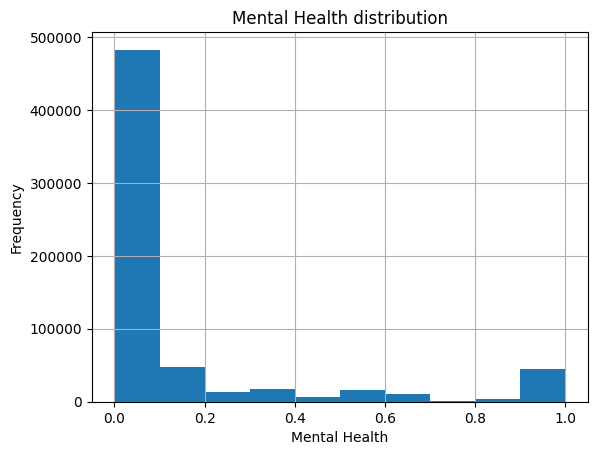

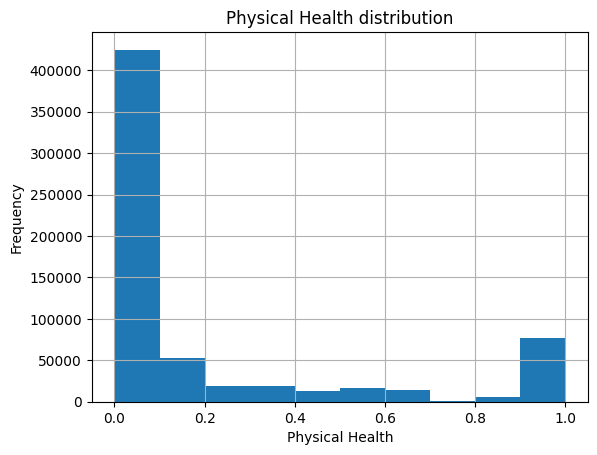

In [11]:

# One-hot encode the 'GenHlth' feature
# keep the original column for now
df['GenHlth_original'] = df['GenHlth']
df = pd.get_dummies(df, columns=['GenHlth'], prefix='GenHlth').astype(int)

# Normalize 'MentHlth' and 'PhysHlth' to a 0-1 range
scaler = MinMaxScaler()
df[['MentHlth', 'PhysHlth']] = scaler.fit_transform(df[['MentHlth', 'PhysHlth']])
df.head()

# Display the distribution of the 'MentHlth' feature
df['MentHlth'].hist(bins=10)
plt.title('Mental Health distribution')
plt.xlabel('Mental Health')
plt.ylabel('Frequency')
plt.show()

# Display the distribution of the 'PhysHlth' feature

df['PhysHlth'].hist(bins=10)
plt.title('Physical Health distribution')
plt.xlabel('Physical Health')
plt.ylabel('Frequency')
plt.show()



The **Mental Health** and **Physical Health** distributions are highly imbalanced, with the majority of respondents reporting very few or no days of poor health (values near 0 on the normalized scale). This imbalance could impact a model's ability to learn patterns for individuals with more frequent poor health days, as they are underrepresented in the data. 

To address this imbalance, we could group the days into broader categories to reduce imbalance while capturing meaningful variations.

In [12]:
# Binning the 'MentHlth' and 'PhysHlth' features
"""
    0: None
    1-5: Few
    6-15: Moderate
    16-30: Many
"""
def bin_health_days(days):
    if days == 0:
        return "None"         
    elif 1 <= days <= 5:
        return "Few"           
    elif 6 <= days <= 15:
        return "Moderate"    
    else:
        return "Many"       

# Apply the binning function to both MentHlth and PhysHlth
df['MentHlth_binned'] = df['MentHlth'].apply(bin_health_days)
df['PhysHlth_binned'] = df['PhysHlth'].apply(bin_health_days)
df[['MentHlth', 'MentHlth_binned', 'PhysHlth', 'PhysHlth_binned']].head()



,MentHlth,MentHlth_binned,PhysHlth,PhysHlth_binned
0,0.6,Many,0.5,Many
1,0.0,None,0.0,None
2,1.0,Few,1.0,Few
3,0.0,None,0.0,None
4,0.1,Many,0.0,None


## Milestone 3 ## 

### Data Description

This project leverages data from the **Behavioral Risk Factor Surveillance System (BRFSS)**, a large-scale health-related telephone survey conducted annually by the CDC. The BRFSS collects responses from over 400,000 Americans on topics including health-related behaviors, chronic health conditions, and the use of preventive services. Our dataset, derived from this survey, contains responses from around 250,000 individuals and focuses on 22 selected features relevant to diabetes prediction. The BRFSS has been conducted every year since 1984, providing a reliable and comprehensive source for health-related research.

The target variable in this dataset indicates diabetes onset, with three categories: 
- **0** for no diabetes (or gestational diabetes only), 
- **1** for prediabetes, and 
- **2** for diabetes (either Type 1 or Type 2, without differentiation). 
Our objective is to predict these outcomes based on patient responses to survey questions, identifying potential risk factors for diabetes onset.

#### Data Collection Process
The data was collected via telephone surveys, with questions covering various aspects of health, lifestyle, and demographics. For this project, only 22 columns were selected out of the full survey, focusing on attributes most likely to influence or indicate diabetes risk.

#### Data Preprocessing
Data preprocessing included several steps to prepare the dataset for analysis:
- **Class Imbalance Adjustment**: We used techniques like SMOTE to address class imbalance, especially since categories 1 (prediabetes) and 2 (diabetes) were underrepresented compared to category 0.
- **Feature Engineering**: Continuous features, such as BMI, were transformed into categories to enhance interpretability. We combined and grouped certain categories (e.g., income, education) to simplify analysis and reduce skewness. We use one hot encoding.
- **Scaling and Normalization**: Features like **MentHlth** and **PhysHlth** (indicating days of poor mental and physical health) were normalized on a 0-1 scale for consistency across variables.


## Data Summary
The dataset underwent extensive cleaning, transformation, and validation to ensure readiness for analysis. We started by examining and addressing class imbalances, particularly in target variables, using techniques like SMOTE to balance underrepresented groups. Continuous features, such as **BMI**, were transformed into categories to improve interpretability, while ordinal and categorical variables, like **Income** and **Education**, were one-hot encoded or grouped into broader categories. We standardized numerical features where necessary to handle differences in scale and ensure consistency. Key health indicators, including **GenHlth**, **MentHlth**, and **PhysHlth**, represent self-reported general, mental, and physical health, respectively, with values indicating frequency or severity. The final dataset includes a mix of demographic, lifestyle, and health-related features, fully refined and ready for exploratory analysis. Visualizations such as histograms and correlation plots provide insights into feature distributions and relationships, supporting further analysis and modeling.

In [13]:
df.head()

# list of all columns
df.columns

# datatypes of all columns
df.dtypes


HighBP                    int64
HighChol                  int64
CholCheck                 int64
BMI                       int64
Smoker                    int64
Stroke                    int64
HeartDiseaseorAttack      int64
PhysActivity              int64
Fruits                    int64
Veggies                   int64
HvyAlcoholConsump         int64
AnyHealthcare             int64
NoDocbcCost               int64
MentHlth                float64
PhysHlth                float64
DiffWalk                  int64
Sex                       int64
Income                    int64
Diabetes_012              int64
Income_Low-income         int64
Income_Mid-income         int64
Income_High-income        int64
Education_original        int64
Education_1               int64
Education_2               int64
Education_3               int64
Education_4               int64
Age_original              int64
Age_1                     int64
Age_2                     int64
Age_3                     int64
Age_4   

## EDA ##


/var/folders/57/9j8h4t_n3czcyzxfglct7ty00000gn/T/ipykernel_2111/182991303.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Diabetes_012', palette='viridis')


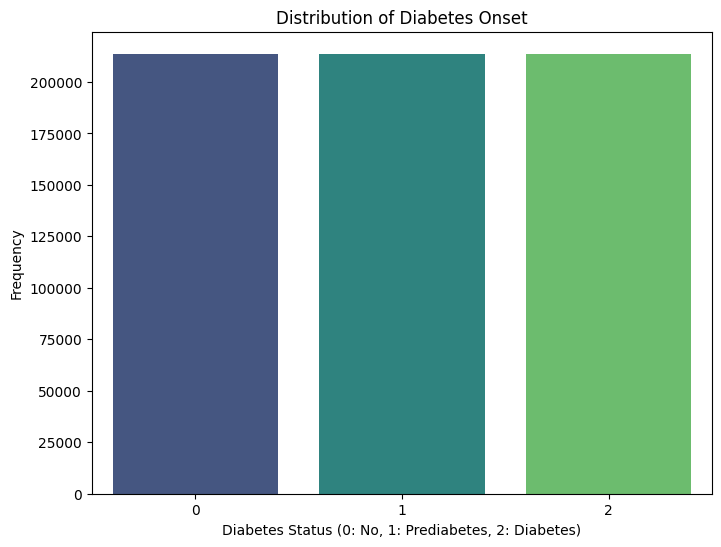

In [14]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Diabetes_012', palette='viridis')
plt.title('Distribution of Diabetes Onset')
plt.xlabel('Diabetes Status (0: No, 1: Prediabetes, 2: Diabetes)')
plt.ylabel('Frequency')
plt.show()

The distribution is now evenly split among the categories of No Diabetes, Prediabetes, and Diabetes. This balance is achieved through the use of SMOTE, which addresses the original imbalance by increasing the representation of diabetes cases relative to non-diabetes cases.

/var/folders/57/9j8h4t_n3czcyzxfglct7ty00000gn/T/ipykernel_2111/2062233344.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='BMI', palette='muted')


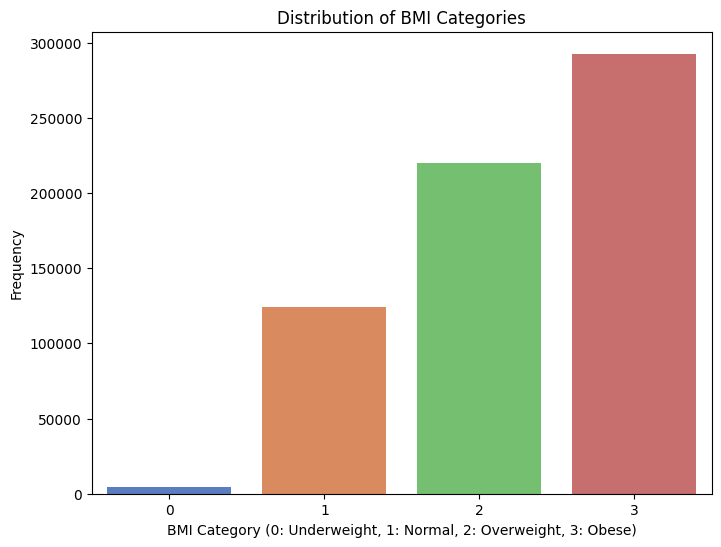

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='BMI', palette='muted')
plt.title('Distribution of BMI Categories')
plt.xlabel('BMI Category (0: Underweight, 1: Normal, 2: Overweight, 3: Obese)')
plt.ylabel('Frequency')
plt.show()


We see some data imbalance as there is a very low number of peoeple that fall in the underweight group which could lead to missrepresentation of this group in the final models.

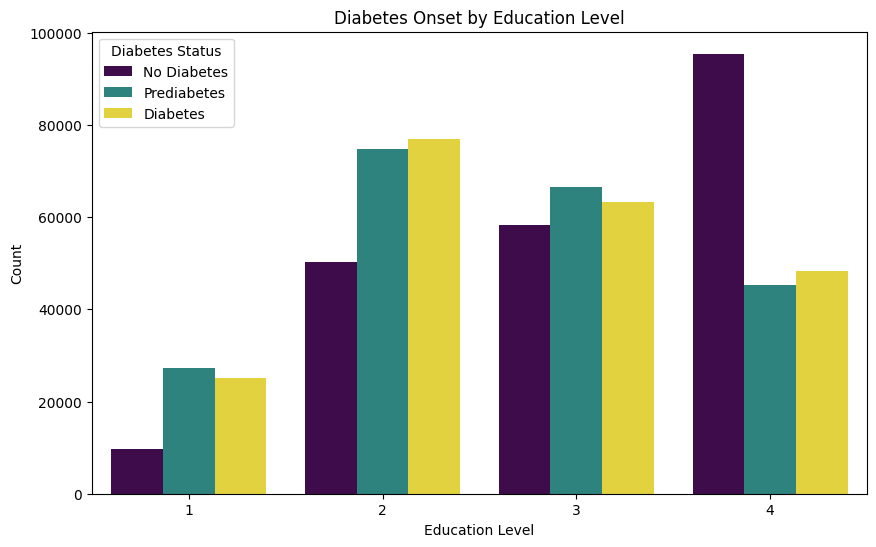

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Education_original', hue='Diabetes_012', palette='viridis')
plt.title('Diabetes Onset by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()

The graph above shows that people with higher education levels are less likely to have diabetes. This could be because higher education often brings more knowledge about healthy habits, like eating well, staying active, and managing stress—habits that help prevent diabetes. Additionally, people with more education may have better access to healthcare and healthier food options, which can also lower their risk of developing diabetes.

Seeing this, we recognize that education level is an important feature to include in our model for explaining diabetes risk. By incorporating education as a predictor, we can improve the model’s ability to capture underlying social and lifestyle factors that contribute to diabetes outcomes.

However, an issue with education as a predictor is that possibility of a cofounding variable such as family background. A survey participant who came from a high-income family is likely to be able to efford higher education and healtcare so by only considering education as a predictor, we are likely overestimating the effect it has on our response variable.

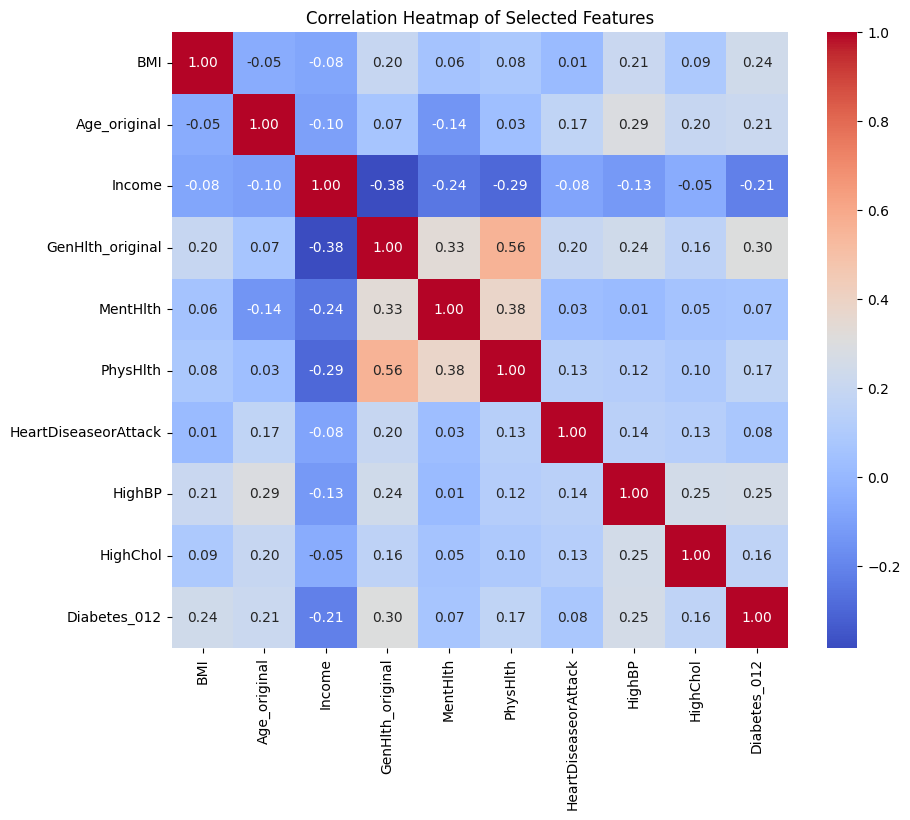

In [17]:

selected_features = ['BMI', 'Age_original', 'Income', 'GenHlth_original', 'MentHlth', 'PhysHlth', 
                     'HeartDiseaseorAttack', 'HighBP', 'HighChol', 'Diabetes_012']

# Generate the correlation heatmap for the selected features
plt.figure(figsize=(10, 8))
corr_matrix = df[selected_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


**GenHlth** (0.30): General health shows the strongest positive correlation with diabetes, indicating that individuals reporting poorer general health are more likely to develop diabetes.

**HighBP** (0.25): High blood pressure is strongly associated with diabetes risk, possibly due to shared lifestyle factors like diet and physical inactivity. Including this feature helps the model capture health patterns tied to diabetes.

**BMI** (0.24): Body Mass Index is another significant predictor, as higher BMI can impair insulin sensitivity, increasing the likelihood of diabetes onset. This highlights the role of weight management and lifestyle in prevention.

**Age** (0.21): Age has a positive correlation, with older age groups at higher risk, aligning with the fact that diabetes prevalence typically increases with age.

**PhysHlth** (0.17): Physical health has a positive correlation with diabetes which is inutitive as an individual with a healthier lifestyle is less likely to get diabetes.

**HighChol** (0.16): High cholesterol, often linked with poor dietary habits, is moderately associated with diabetes risk, suggesting its relevance as a supporting feature in prediction.

**Income** (-0.21): Income has a negative correlation to diabetes which makes sense as individuals with higher incomes can afford a healthier lifestyle and higher quality healthcare which leads to lower likelyhood of diabetes.

GenHlth and HighBP show the strongest associations, making them particularly influential features in predicting diabetes risk.

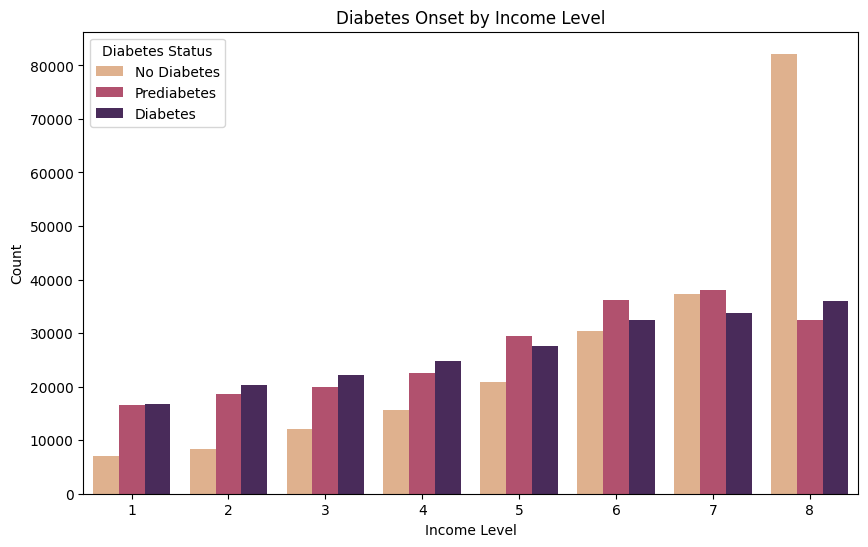

In [18]:
# Income Level vs Diabetes Onset
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Income', hue='Diabetes_012', palette='flare')
plt.title('Diabetes Onset by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()


As shown in the graph above, income is strongly correlated with diabetes risk. Higher-income individuals tend to have better access to a healthy lifestyle, including options like organic food, regular healthcare, and preventive resources. This access supports healthier habits, which may reduce their likelihood of developing diabetes.

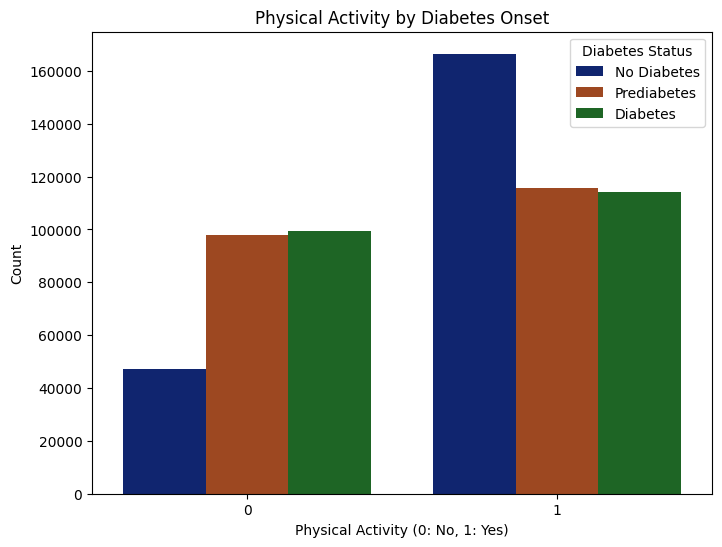

In [19]:
# General Health vs Diabetes Onset
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='PhysActivity', hue='Diabetes_012', palette='dark')
plt.title('Physical Activity by Diabetes Onset')
plt.xlabel('Physical Activity (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()

People who are more physically active are more likely to maintain good health and have a lower risk of developing diabetes. Regular physical activity helps manage weight, improves insulin sensitivity, and supports overall metabolic health, all of which are key factors in reducing diabetes risk.

As we go throuh the EDA, one might notice an issue of collinearity within the dataset, where certain features are highly correlated with each other. We’ll delve into this potential problem in more detail below in the ending of the notebook.

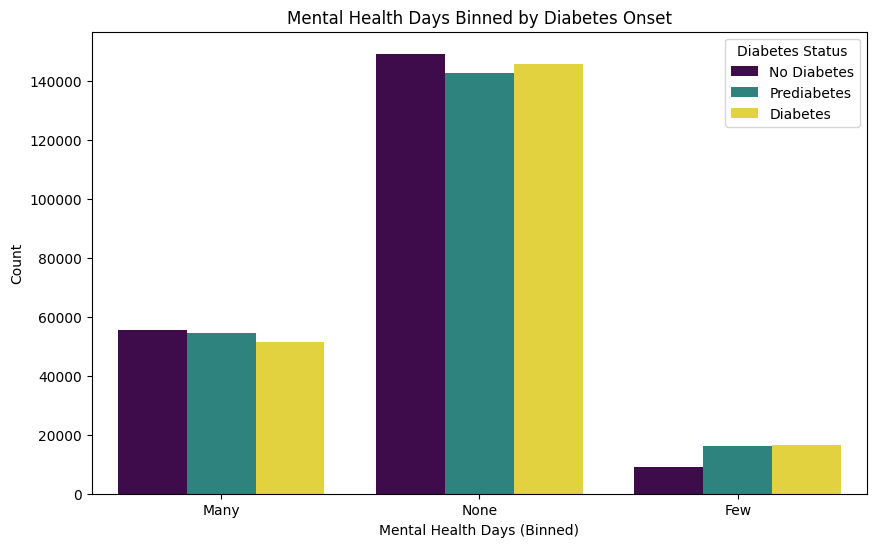

In [20]:

# MentHlth Days Binned vs Diabetes Onset
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='MentHlth_binned', hue='Diabetes_012', palette='viridis')
plt.title('Mental Health Days Binned by Diabetes Onset')
plt.xlabel('Mental Health Days (Binned)')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()


The mental health days count does not show a clear distinction across diabetes classes among the categories "many," "none," and "few." This lack of separation suggests that mental health days may not be a strong predictor of diabetes on its own. However, this is an area that should be further explored to determine if there might be subtler patterns or interactions with other features that could contribute to diabetes prediction.

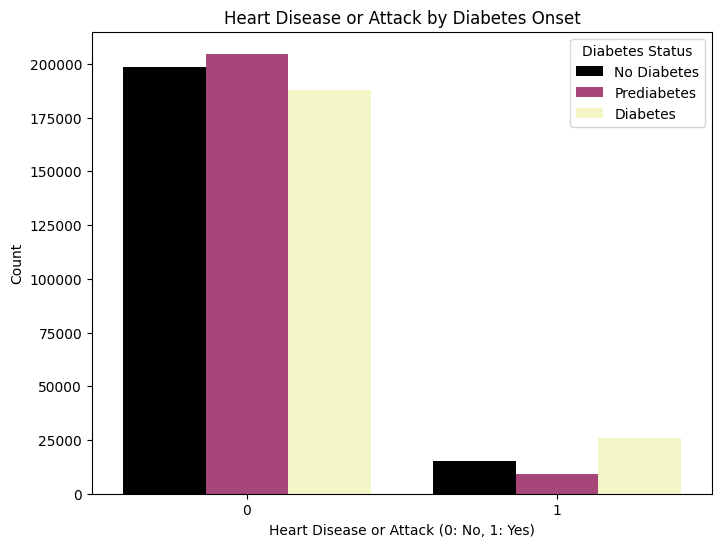

In [21]:
# Heart Disease or Attack vs Diabetes Onset
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='HeartDiseaseorAttack', hue='Diabetes_012', palette='magma')
plt.title('Heart Disease or Attack by Diabetes Onset')
plt.xlabel('Heart Disease or Attack (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()

As we saw in the heatmap, there seems to be a correlation between prediabetes and a history of heart attack. This relationship could be explained by the fact that individuals who have experienced a heart attack may be more motivated to improve their diet and lifestyle to prevent further health issues, potentially delaying or managing diabetes progression.

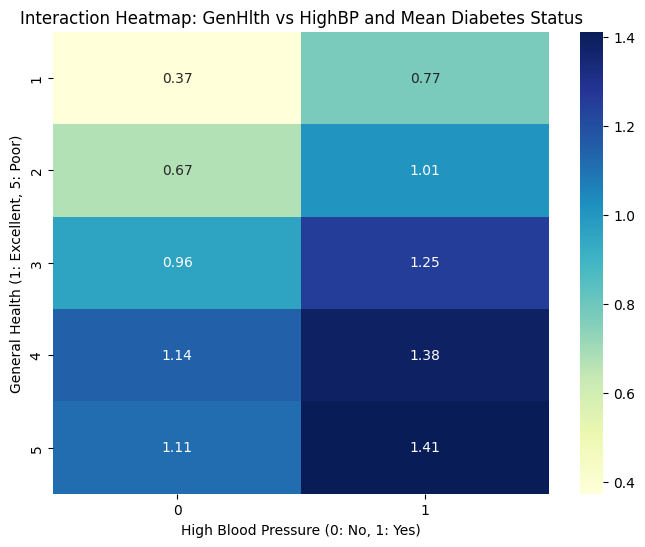

In [22]:
interaction_data_health = df.groupby(['GenHlth_original', 'HighBP'])['Diabetes_012'].mean().unstack().fillna(0)
plt.figure(figsize=(8, 6))
sns.heatmap(interaction_data_health, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
plt.title('Interaction Heatmap: GenHlth vs HighBP and Mean Diabetes Status')
plt.xlabel('High Blood Pressure (0: No, 1: Yes)')
plt.ylabel('General Health (1: Excellent, 5: Poor)')
plt.show()


This heatmap visualizes the interaction between general health index and high blood pressure in relation to the mean diabetes status. Here’s what we observe:

As the general health index worsens (from 1 for excellent to 5 for poor), the average diabetes status increases for both people with and without high blood pressure. This trend suggests that poorer self-reported health is associated with a higher likelihood of diabetes, regardless of blood pressure status. However, individuals with high blood pressure generally show a slightly higher mean diabetes status across all levels of general health compared to those without high blood pressure.

## Base modeling
Creating a base model with the majority class now is impossible specificallly for the diabetes_012 column since we equalized them because there is a class imbalance we don't want to affect our predictions. We want to strictly use predictors to learn our diabetes status. We choose knn or logistic regression as some baseline model.


In [23]:
# Define predictors and target based on correlation analysis
predictors = ['GenHlth_original', 'HighBP', 'BMI', 'Age_original','PhysHlth' , 'HighChol', 'Income']
X = df[predictors]
y = df['Diabetes_012']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_k = 5
best_accuracy = 0
k_values = list(range(5, 40))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# Plot the accuracy values for each k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()


best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred_knn = best_knn.predict(X_test)
print("Best KNN Parameters:", best_k)
print("Best KNN Accuracy:", best_accuracy)
print(classification_report(y_test, y_pred_knn))

KeyboardInterrupt: 

The model achieves an overall accuracy of 59%, meaning it correctly predicts diabetes status slightly over half the time. Its recall, particularly for classes representing prediabetes is moderate but not high, indicating it misses a substantial number of actual diabetes and non-diabetes cases. This performance could be due to overlapping features between classes, where factors like general health, blood pressure, and BMI may not provide enough distinct information for clear class separation.

Best Logistic Regression Parameters: {'C': 0.001}
Logistic Regression Accuracy: 0.5132894511082342
              precision    recall  f1-score   support

           0       0.56      0.61      0.58     42688
           1       0.47      0.34      0.39     42676
           2       0.50      0.59      0.54     42858

    accuracy                           0.51    128222
   macro avg       0.51      0.51      0.51    128222
weighted avg       0.51      0.51      0.51    128222



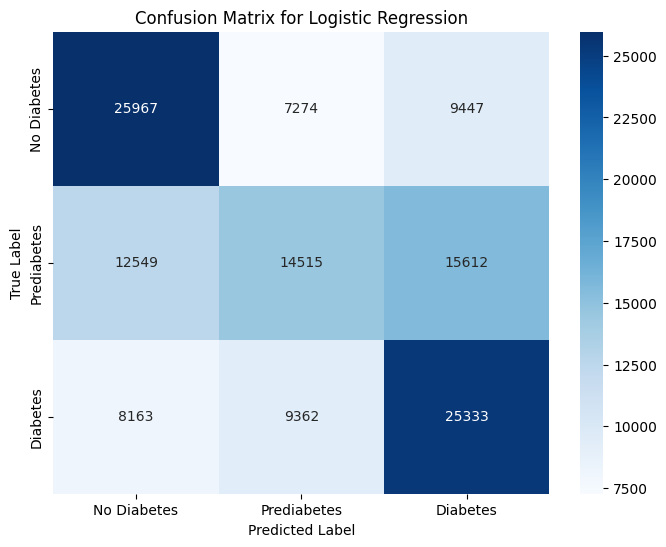

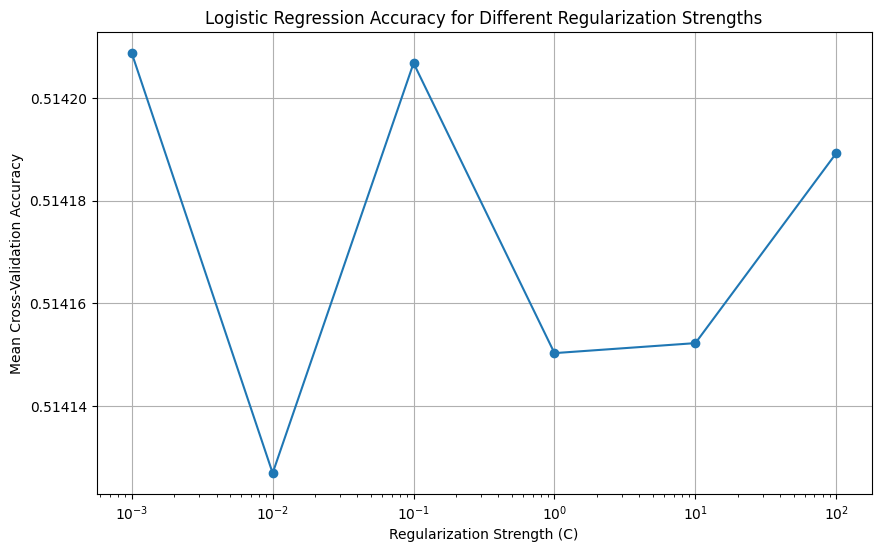

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logistic = LogisticRegression(max_iter=1000, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
grid_search_logistic = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')
grid_search_logistic.fit(X_train, y_train)
best_logistic = grid_search_logistic.best_estimator_
y_pred_logistic = best_logistic.predict(X_test)

print("Best Logistic Regression Parameters:", grid_search_logistic.best_params_)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Plot accuracy vs. regularization strength (C) for analysis
accuracy_scores = grid_search_logistic.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(param_grid['C'], accuracy_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Logistic Regression Accuracy for Different Regularization Strengths')
plt.grid(True)
plt.show()


This Logistic Regression model achieves an accuracy of approximately 51.3%. It performs moderately well in identifying "No Diabetes" and "Diabetes" cases but struggles with "Prediabetes," as seen in lower precision and recall for that class. The best regularization parameter C=0.001 balances model fit without overfitting. Misclassifications, especially between "Prediabetes" and "Diabetes," suggest that further feature engineering or a different model may be needed to improve differentiation among classes.

Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.6267567188158039
              precision    recall  f1-score   support

           0       0.66      0.59      0.62     42688
           1       0.61      0.68      0.64     42676
           2       0.61      0.61      0.61     42858

    accuracy                           0.63    128222
   macro avg       0.63      0.63      0.63    128222
weighted avg       0.63      0.63      0.63    128222



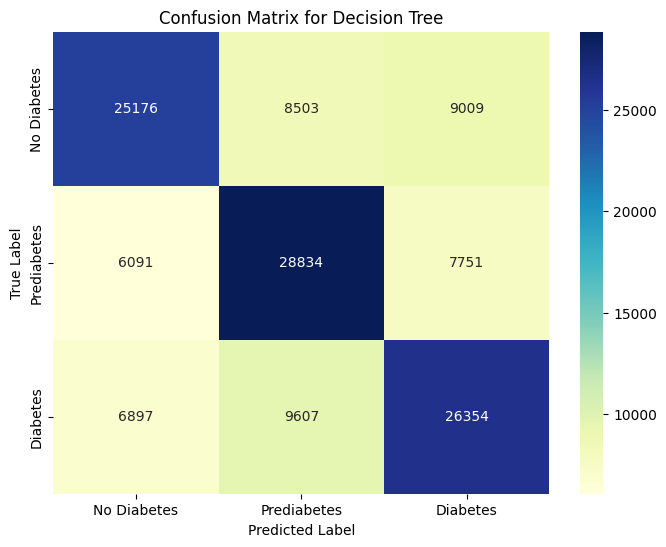

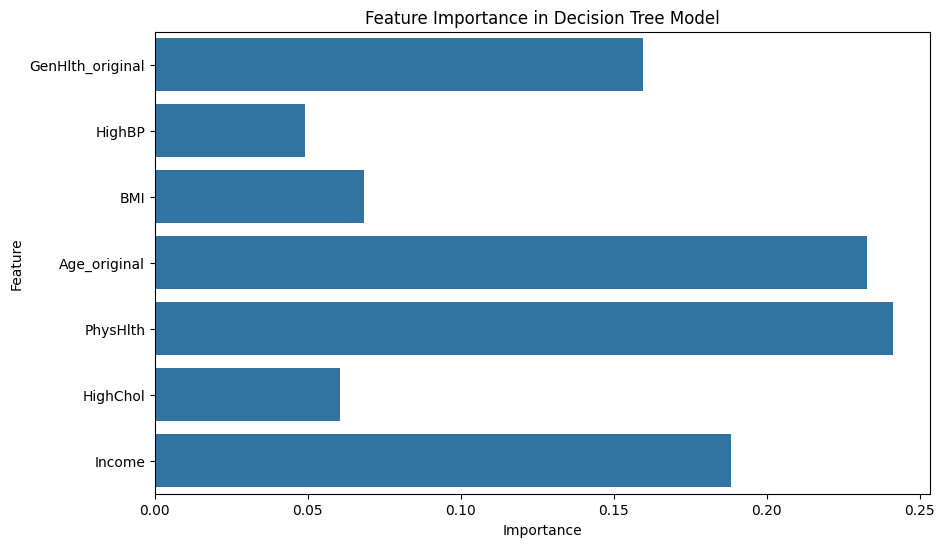

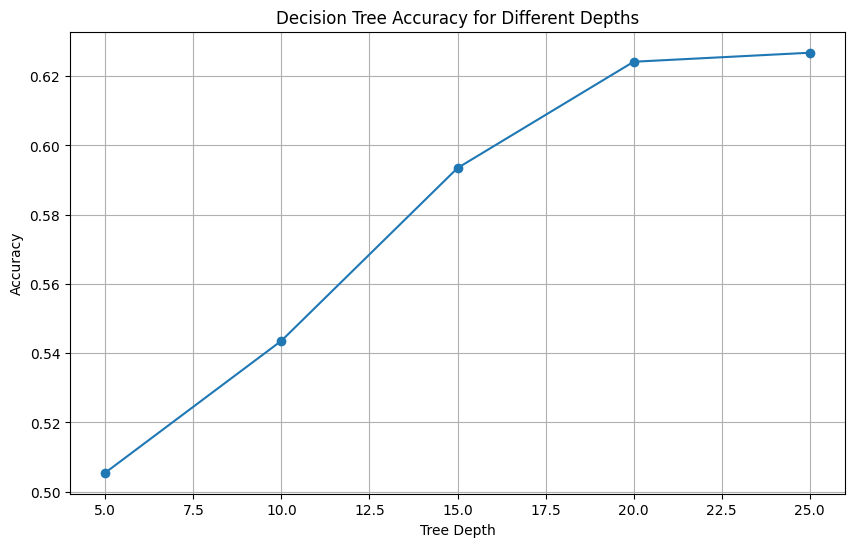

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations
tree = DecisionTreeClassifier(random_state=42)

# Set up hyperparameters for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search_tree.fit(X_train, y_train)

best_tree = grid_search_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)

print("Best Decision Tree Parameters:", grid_search_tree.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

conf_matrix = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


feature_importances = best_tree.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=predictors)
plt.title('Feature Importance in Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot accuracy vs depth
depths = [5, 10, 15, 20, 25]
accuracies = []
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o', linestyle='-') 
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy for Different Depths')
plt.grid(True)
plt.show()

The Decision Tree model achieved an accuracy of 62.7%, showing moderate performance across diabetes classes. Hyperparameter tuning helped enhance the model, with depth and splitting criteria improving accuracy. From the feature importance graph, we can see that general health index, physical health, income and age are the most influential predictors, indicating that overall health, income and age-related factors play a crucial role in predicting diabetes risk.

Decision Tree Accuracy: 0.5488449720016846
              precision    recall  f1-score   support

           0       0.61      0.56      0.58     42688
           1       0.50      0.55      0.52     42676
           2       0.55      0.53      0.54     42858

    accuracy                           0.55    128222
   macro avg       0.55      0.55      0.55    128222
weighted avg       0.55      0.55      0.55    128222



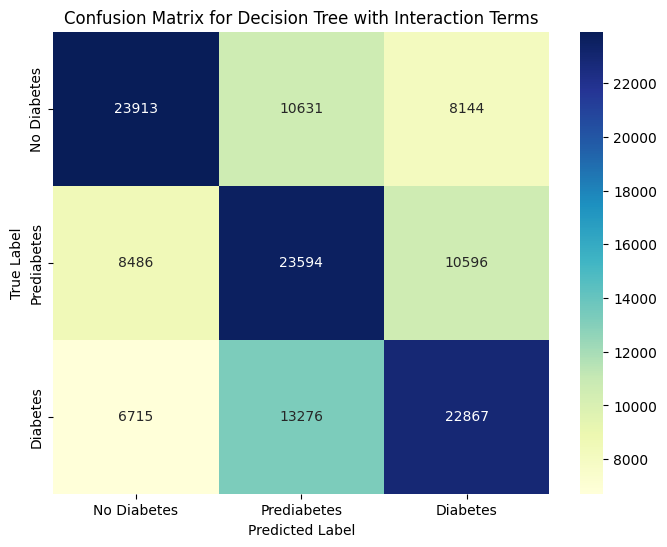

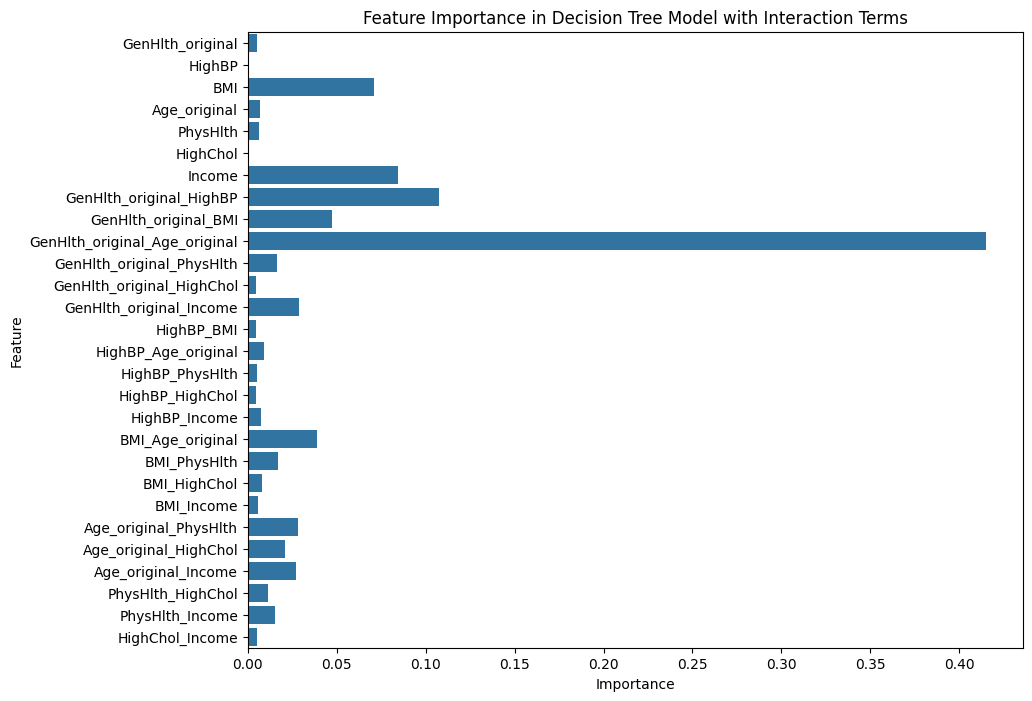

In [ ]:
predictors = ['GenHlth_original', 'HighBP', 'BMI', 'Age_original','PhysHlth' , 'HighChol', 'Income']
X = df[predictors].copy()
y = df['Diabetes_012']

for feature1, feature2 in combinations(predictors, 2):
    interaction_name = f"{feature1}_{feature2}"
    X.loc[:, interaction_name] = X[feature1] * X[feature2]

all_features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

conf_matrix = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree with Interaction Terms')
plt.show()

feature_importances = tree.feature_importances_
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=all_features)
plt.title('Feature Importance in Decision Tree Model with Interaction Terms')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
start_time = time.time()
# minutes
print("--- %s minutes ---" % ((time.time() - start_time)/60))

# Note on Colinearity

As we progressed through the exploratory data analysis, we identified several important relationships and features that will be used in future modeling. However, a potential challenge we need to address is collinearity among these features, as many of them—such as general health, physical health, BMI, and activity level—are strongly interrelated and ultimately reflect a person’s overall lifestyle. This overlap can complicate the model’s ability to distinguish the unique contribution of each feature, potentially explaining why the current model results, while reasonable, may be somewhat underwhelming. In the next milestone, we’ll work on strategies to address collinearity, such as dimensionality reduction or feature selection, to enhance model clarity and predictive accuracy. With these adjustments, we expect that the model’s performance will improve, making this analysis a solid foundation for building a robust diabetes prediction model.



# Summary

We have identified a few predictors with the highest correlation to diabetes as the response variable. Additionally, we have analyzied 4 models, kNN, Logistical Regression, Regular Decisions Tree and Decision Tree with Interactions and have found that the highest accuracy is achieved with a Regula Decision Tree model. Additionally, this model assures our prior findings that the most important predictors are Physical Health, Age, General Health and Income. 

Additionally, we plan to continue looking at new models such as Random Forrest Model in hopes of arriving at a higher accuracy.
